In [1]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Preprocessing

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import json
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm


# -------- Tokenizer --------
def nltk_tokenizer(text):
    return word_tokenize(text.lower())


# -------- Read JSON (for DBPedia) --------
def load_dbpedia_data(train_path, val_path, test_path=None):
    # ---- train ----
    with open(train_path, "r", encoding="utf-8") as f:
        train_data = json.load(f)
    train_texts = [item["text"] for item in train_data]
    train_labels = [int(item["label"]) for item in train_data]

    # ---- val ----
    with open(val_path, "r", encoding="utf-8") as f:
        val_data = json.load(f)
    val_texts = [item["text"] for item in val_data]
    val_labels = [int(item["label"]) for item in val_data]

    # ---- test ----
    if test_path is not None:
        with open(test_path, "r", encoding="utf-8") as f:
            test_data = json.load(f)
        test_texts = [item["text"] for item in test_data]
        test_ids = [item.get("id", i) for i, item in enumerate(test_data)]
    else:
        test_texts, test_ids = [], []

    num_classes = max(train_labels + val_labels) + 1

    return train_texts, train_labels, val_texts, val_labels, test_texts, test_ids, num_classes


# -------- Vocab --------
class Vocab:
    def __init__(self, tokens_list, min_freq=1):
        counter = Counter()
        for tokens in tokens_list:
            counter.update(tokens)

        self.itos = ["<unk>", "<pad>"] + [tok for tok, freq in counter.items() if freq >= min_freq]
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi.get(token, self.stoi["<unk>"])


# -------- Dataset --------
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, vocab=None, max_len=128):
        self.tokens_list = [nltk_tokenizer(text) for text in tqdm(texts, desc="Tokenizing")]
        self.labels = labels
        self.max_len = max_len

        if vocab is None:
            self.vocab = Vocab(self.tokens_list)
        else:
            self.vocab = vocab

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = self.tokens_list[idx]
        ids = [self.vocab[tok] for tok in tokens[:self.max_len]]

        if len(ids) < self.max_len:
            ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))

        ids = torch.tensor(ids, dtype=torch.long)

        if self.labels is not None:
            label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
            return ids, label
        else:
            return ids


# -------- DataLoader --------
def get_dataloaders(train_texts, train_labels, val_texts, val_labels,
                    batch_size=32, max_len=128):
    train_dataset = TextDataset(train_texts, train_labels, max_len=max_len)
    val_dataset = TextDataset(val_texts, val_labels, vocab=train_dataset.vocab, max_len=max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, train_dataset.vocab


# -------- Test Loader --------
def get_test_loader(test_texts, vocab, batch_size=32, max_len=128):
    test_dataset = TextDataset(test_texts, labels=None, vocab=vocab, max_len=max_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader


## 1. Basic SSM

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- basic SSM ---
class DiagonalSSM(nn.Module):
    def __init__(self, state_size: int, dt_init: float = 1.0, init_scale: float = 0.1):
        super().__init__()
        self.state_size = state_size

        # --- Continuous-time parameters ---
        # A: diagonal, so is one-dimensional, negative for stability
        self.A = nn.Parameter(-torch.rand(state_size) * init_scale)

        # B, C: learnable projections
        self.B = nn.Parameter(torch.randn(state_size) * init_scale)
        self.C = nn.Parameter(torch.randn(state_size) * init_scale)

        # Discretization step (Δt)
        self.dt = nn.Parameter(torch.ones(1) * dt_init)

        # Buffers for discretized
        self.register_buffer("A_bar", torch.zeros(state_size))
        self.register_buffer("B_bar", torch.zeros(state_size))

        self._discretize()

    def _discretize(self):
        """
        Compute discrete-time:
            A_bar = exp(A * dt)
            B_bar = (exp(A * dt) - 1) / A * B
        (diagonal version of zero-order hold discretization)
        """
        A_dt = self.A * self.dt  # (state_size)
        self.A_bar = torch.exp(A_dt)

        # Handle division by zero for A ≈ 0
        self.B_bar = torch.where(
            self.A.abs() > 1e-5,
            (self.A_bar - 1.0) / self.A * self.B,
            self.dt * self.B,
        )

    def forward(self, u):
        """
        u: (B, L, 1)
        return: (B, L, state_size)
        """
        B, L, _ = u.shape
        self._discretize()  

        # State h: (B, state_size)
        h = torch.zeros(B, self.state_size, device=u.device)
        outputs = []

        # scan over sequence
        for t in range(L):
            u_t = u[:, t, 0]                     
            h = self.A_bar * h + self.B_bar * u_t.unsqueeze(-1)
            y_t = h * self.C                    
            outputs.append(y_t)

        return torch.stack(outputs, dim=1)

# --- Block ---
class SSMBlock(nn.Module):
    def __init__(self, in_dim: int, state_size: int, dropout: float = 0.1):
        super().__init__()
        self.proj_in = nn.Linear(in_dim, 1)
        self.ssm = DiagonalSSM(state_size)
        self.proj_out = nn.Linear(state_size, in_dim)
        self.gate = nn.Sigmoid()
        self.norm = nn.LayerNorm(in_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        u = self.proj_in(x)
        y = self.ssm(u)
        y = self.proj_out(y)
        y = self.gate(y) * y
        y = self.dropout(y)
        return self.norm(residual + y)


# --- Text Classifier ---
class SSMTextClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_classes: int, state_size: int, num_layers: int,
             emb_dim: int = 128, dropout: float = 0.1, pad_idx: int = 0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.blocks = nn.ModuleList([SSMBlock(emb_dim, state_size, dropout) for _ in range(num_layers)])
        self.head = nn.Linear(emb_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        x = self.emb(input_ids)
        for blk in self.blocks:
            x = blk(x)
        pooled = x.mean(dim=1)
        return self.head(self.dropout(pooled))

In [5]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt


def train_SSM(train_texts, train_labels, val_texts, val_labels,
              num_classes, epochs, batch_size, max_len,
              emb_dim, state_size, num_layers, lr,
              device="cuda"):

    train_loader, val_loader, vocab = get_dataloaders(
        train_texts, train_labels, val_texts, val_labels,
        batch_size=batch_size, max_len=max_len
    )

    pad_idx = vocab.stoi["<pad>"]
    model = SSMTextClassifier(
        vocab_size=len(vocab),
        num_classes=num_classes,
        emb_dim=emb_dim,
        state_size=state_size,
        num_layers=num_layers,
        dropout=0.1,
        pad_idx=pad_idx
    ).to(device)

    classes = np.unique(train_labels)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler("cuda")

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # --- training ---
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", unit="batch")

        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(correct / total):.4f}"
            })

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Valid {epoch+1}/{epochs}", unit="batch")
            for xb, yb in pbar_val:
                xb, yb = xb.to(device), yb.to(device)
                with torch.amp.autocast("cuda"):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        train_acc = correct / total
        val_acc = val_correct / val_total
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()    
    plt.savefig('basic_loss_curve.png')

    return model, vocab

In [6]:
import time 

def main_SSM(
    train_path,
    valid_path,
    epochs,
    batch_size,
    max_len,
    emb_dim,
    state_size,
    num_layers,
    lr
):

    train_texts, train_labels, val_texts, val_labels, _, _, num_classes = load_dbpedia_data(
        train_path,
        valid_path,
        None
    )

    start_time = time.time()
    model, vocab = train_SSM(
        train_texts, train_labels, val_texts, val_labels,
        num_classes=num_classes,
        epochs=epochs,
        batch_size=batch_size,
        max_len=max_len,
        emb_dim=emb_dim,
        state_size=state_size,
        num_layers=num_layers,
        lr=lr
    )
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    return model, vocab


Valid 1/20: 100%|██████████| 125/125 [00:01<00:00, 72.54batch/s]


Epoch 1/20 | Train Acc: 0.1756 | Val Acc: 0.2980 | Train Loss: 2.4459 | Val Loss: 2.0924


Valid 2/20: 100%|██████████| 125/125 [00:01<00:00, 73.25batch/s]


Epoch 2/20 | Train Acc: 0.3588 | Val Acc: 0.4525 | Train Loss: 1.8570 | Val Loss: 1.6086


Valid 3/20: 100%|██████████| 125/125 [00:01<00:00, 73.26batch/s]


Epoch 3/20 | Train Acc: 0.4638 | Val Acc: 0.5420 | Train Loss: 1.5287 | Val Loss: 1.3850


Valid 4/20: 100%|██████████| 125/125 [00:01<00:00, 72.19batch/s]


Epoch 4/20 | Train Acc: 0.5282 | Val Acc: 0.5975 | Train Loss: 1.3127 | Val Loss: 1.1666


Valid 5/20: 100%|██████████| 125/125 [00:01<00:00, 73.08batch/s]


Epoch 5/20 | Train Acc: 0.6018 | Val Acc: 0.6260 | Train Loss: 1.1208 | Val Loss: 1.1008


Valid 6/20: 100%|██████████| 125/125 [00:01<00:00, 71.61batch/s]


Epoch 6/20 | Train Acc: 0.6500 | Val Acc: 0.6325 | Train Loss: 0.9868 | Val Loss: 1.0828


Valid 7/20: 100%|██████████| 125/125 [00:01<00:00, 72.48batch/s]


Epoch 7/20 | Train Acc: 0.6958 | Val Acc: 0.6900 | Train Loss: 0.8817 | Val Loss: 0.9232


Valid 8/20: 100%|██████████| 125/125 [00:01<00:00, 72.15batch/s]


Epoch 8/20 | Train Acc: 0.7212 | Val Acc: 0.7070 | Train Loss: 0.7959 | Val Loss: 0.8552


Valid 9/20: 100%|██████████| 125/125 [00:01<00:00, 72.52batch/s]


Epoch 9/20 | Train Acc: 0.7496 | Val Acc: 0.7065 | Train Loss: 0.7330 | Val Loss: 0.8184


Valid 10/20: 100%|██████████| 125/125 [00:01<00:00, 73.07batch/s]


Epoch 10/20 | Train Acc: 0.7808 | Val Acc: 0.7405 | Train Loss: 0.6573 | Val Loss: 0.7951


Valid 11/20: 100%|██████████| 125/125 [00:01<00:00, 73.18batch/s]


Epoch 11/20 | Train Acc: 0.7886 | Val Acc: 0.6945 | Train Loss: 0.6193 | Val Loss: 0.8903


Valid 12/20: 100%|██████████| 125/125 [00:01<00:00, 73.02batch/s]


Epoch 12/20 | Train Acc: 0.8074 | Val Acc: 0.7445 | Train Loss: 0.5740 | Val Loss: 0.7565


Valid 13/20: 100%|██████████| 125/125 [00:01<00:00, 73.10batch/s]


Epoch 13/20 | Train Acc: 0.8308 | Val Acc: 0.7655 | Train Loss: 0.5220 | Val Loss: 0.7300


Valid 14/20: 100%|██████████| 125/125 [00:01<00:00, 72.76batch/s]


Epoch 14/20 | Train Acc: 0.8434 | Val Acc: 0.7670 | Train Loss: 0.4801 | Val Loss: 0.7212


Valid 15/20: 100%|██████████| 125/125 [00:01<00:00, 71.78batch/s]


Epoch 15/20 | Train Acc: 0.8522 | Val Acc: 0.7585 | Train Loss: 0.4404 | Val Loss: 0.7688


Valid 16/20: 100%|██████████| 125/125 [00:01<00:00, 73.23batch/s]


Epoch 16/20 | Train Acc: 0.8732 | Val Acc: 0.7890 | Train Loss: 0.3965 | Val Loss: 0.6889


Valid 17/20: 100%|██████████| 125/125 [00:01<00:00, 71.74batch/s]


Epoch 17/20 | Train Acc: 0.8916 | Val Acc: 0.7840 | Train Loss: 0.3602 | Val Loss: 0.7118


Valid 18/20: 100%|██████████| 125/125 [00:01<00:00, 72.85batch/s]


Epoch 18/20 | Train Acc: 0.8998 | Val Acc: 0.7855 | Train Loss: 0.3376 | Val Loss: 0.7088


Valid 19/20: 100%|██████████| 125/125 [00:01<00:00, 72.83batch/s]


Epoch 19/20 | Train Acc: 0.9088 | Val Acc: 0.7950 | Train Loss: 0.3085 | Val Loss: 0.6958


Valid 20/20: 100%|██████████| 125/125 [00:01<00:00, 73.44batch/s]


Epoch 20/20 | Train Acc: 0.9098 | Val Acc: 0.7610 | Train Loss: 0.2984 | Val Loss: 0.8102
Training time: 513.51 seconds


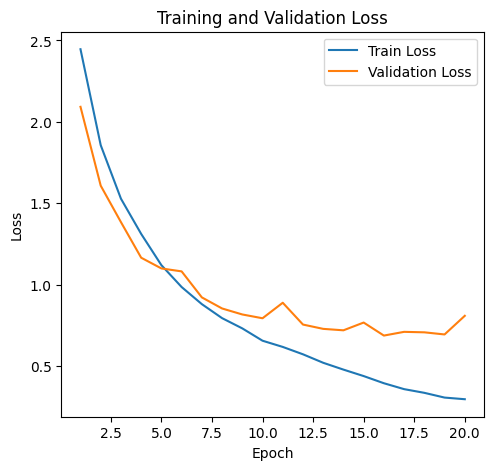

In [10]:
train_path = "/kaggle/input/dataset-llm/train.json"
valid_path = "/kaggle/input/dataset-llm/val.json"

model, vocab = main_SSM(
    train_path, valid_path,
    epochs=20,
    batch_size=16,
    max_len=64,
    emb_dim=128,
    state_size=32,
    num_layers=3,
    lr=5e-4
)

In [11]:
# predict on test.json
test_path = "/kaggle/input/dataset-llm/test.json"

def predict_test(model, vocab, test_path, batch_size=32, max_len=128, device="cuda"):
    test_texts, test_ids = load_dbpedia_data(train_path, valid_path, test_path)[4:6]
    test_loader = get_test_loader(test_texts, vocab, batch_size=batch_size, max_len=max_len)

    model.eval()
    predictions = []
    with torch.no_grad():
        for xb in tqdm(test_loader, desc="Predicting", unit="batch"):
            xb = xb.to(device)
            with torch.amp.autocast("cuda"):
                logits = model(xb)
            preds = logits.argmax(dim=1).cpu().tolist()
            predictions.extend(preds)

    return list(zip(test_ids, predictions))

preds = predict_test(model, vocab, test_path, batch_size=16, max_len=64, device="cuda")

with open("base_submission.csv", "w") as f:
    f.write("id,label\n")
    for idx, label in preds:
        f.write(f"{idx},{label}\n")

Predicting: 100%|██████████| 125/125 [00:01<00:00, 72.58batch/s]


## 2. FFT-based Convolutional SSM

In [12]:
# --- FFT-based Convolutional SSM (Simplified S4) ---
import torch
import torch.nn as nn
import torch.nn.functional as F

class FFTSSMBlock(nn.Module):
    def __init__(self, seq_len: int, in_dim: int, dropout: float = 0.1):
        super().__init__()
        self.seq_len = seq_len
        self.in_dim = in_dim

        self.A_raw = nn.Parameter(torch.randn(in_dim))       # shape (D,)
        self.B = nn.Parameter(torch.randn(in_dim))           # shape (D,)
        self.C = nn.Parameter(torch.randn(in_dim))           # shape (D,)

        
        self.proj_in = nn.Linear(in_dim, in_dim)
        self.proj_out = nn.Linear(in_dim, in_dim)

        self.norm = nn.LayerNorm(in_dim)
        self.dropout = nn.Dropout(dropout)
        self.gate = nn.Sigmoid()

    def compute_kernel(self, L):
        """
        Compute convolution kernel K of shape (in_dim, L)
        Using A, B, C with exponential decay (S4D-like)
        """
        t = torch.arange(L, device=self.A_raw.device, dtype=torch.float32)  # (L,)
        A = -F.softplus(self.A_raw)  # ensure stability: A < 0
        decay = torch.exp(torch.outer(t, A))  # (L, D)
        K = decay * (self.C * self.B) * 0.1   # (L, D)
        return K.T  # -> (D, L)

    def forward(self, x):
        """
        x: (B, L, D)
        """
        B, L, D = x.shape
        residual = x

        #=== input projection ===#
        u = self.proj_in(x)  # (B, L, D)

        #=== SSM Kernel ===#
        K = self.compute_kernel(L)  # (D, L)

        #=== FFT convolution ===#
        # We convolve each channel separately
        # u: (B, D, L)
        u_f = torch.fft.rfft(u.transpose(1, 2), n=2*L)   # (B, D, ?)
        k_f = torch.fft.rfft(K, n=2*L)                   # (D, ?)

        # Multiply in frequency domain
        y_f = u_f * k_f.unsqueeze(0)                     # (B, D, ?)

        # Inverse FFT to time domain
        y = torch.fft.irfft(y_f, n=2*L)[..., :L]         # (B, D, L)
        y = y.transpose(1, 2)                            # (B, L, D)

        #=== output projection + gate ===#
        y = self.proj_out(y)
        y = self.gate(y) * y
        y = self.dropout(y)

        return self.norm(residual + y)

class S4TextClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_classes: int, seq_len: int,
                 emb_dim=128, num_layers=2, dropout=0.1, pad_idx=0):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)

        self.blocks = nn.ModuleList([
            FFTSSMBlock(seq_len, emb_dim, dropout)
            for _ in range(num_layers)
        ])

        self.head = nn.Linear(emb_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids):
        x = self.emb(input_ids)

        for blk in self.blocks:
            x = blk(x)

        pooled = x.mean(dim=1)
        return self.head(self.dropout(pooled))

In [13]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

def train_S4(
    train_texts, train_labels,
    val_texts, val_labels,
    num_classes,
    epochs=3,
    batch_size=32,
    max_len=128,
    emb_dim=256,
    num_layers=4,
    lr=1e-3,
    device="cuda"
):

    train_loader, val_loader, vocab = get_dataloaders(
        train_texts, train_labels, val_texts, val_labels,
        batch_size=batch_size, max_len=max_len
    )

    pad_idx = vocab.stoi["<pad>"]
    model = S4TextClassifier(
        vocab_size=len(vocab),
        num_classes=num_classes,
        seq_len=max_len,
        emb_dim=emb_dim,
        num_layers=num_layers,
        dropout=0.1,
        pad_idx=pad_idx
    ).to(device)

    classes = np.unique(train_labels)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler("cuda")

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", unit="batch")

        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{(correct / total):.4f}"
            })

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            pbar_val = tqdm(val_loader, desc=f"Valid {epoch+1}/{epochs}", unit="batch")
            for xb, yb in pbar_val:
                xb, yb = xb.to(device), yb.to(device)
                with torch.amp.autocast("cuda"):
                    logits = model(xb)
                    loss = criterion(logits, yb)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        train_acc = correct / total
        val_acc = val_correct / val_total
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()    
    plt.savefig('s4_loss_curve.png')

    return model, vocab


In [14]:
import time
def main_S4(
    train_path,
    val_path,
    test_path,
    epochs,
    batch_size,
    max_len,
    emb_dim,
    num_layers,
    lr
):

    train_texts, train_labels, val_texts, val_labels, test_texts, test_ids, num_classes = load_dbpedia_data(
        train_path, val_path, test_path
    )
    
    start_time = time.time()
    model, vocab = train_S4(
        train_texts, train_labels,
        val_texts, val_labels,
        num_classes=num_classes,
        epochs=epochs,
        batch_size=batch_size,
        max_len=max_len,
        emb_dim=emb_dim,
        num_layers=num_layers,
        lr=lr
    )
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    return model, vocab


Train 1/20:   0%|          | 0/313 [00:00<?, ?batch/s]/tmp/ipykernel_48/36043787.py:51: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /pytorch/aten/src/ATen/EmptyTensor.cpp:50.)
  u_f = torch.fft.rfft(u.transpose(1, 2), n=2*L)   # (B, D, ?)
Valid 1/20: 100%|██████████| 125/125 [00:00<00:00, 225.71batch/s]


Epoch 1/20 | Train Acc: 0.1498 | Val Acc: 0.1720 | Train Loss: 2.5781 | Val Loss: 2.4920


Valid 2/20: 100%|██████████| 125/125 [00:00<00:00, 229.39batch/s]


Epoch 2/20 | Train Acc: 0.3238 | Val Acc: 0.4000 | Train Loss: 2.1807 | Val Loss: 1.8652


Valid 3/20: 100%|██████████| 125/125 [00:00<00:00, 226.66batch/s]


Epoch 3/20 | Train Acc: 0.5178 | Val Acc: 0.4870 | Train Loss: 1.4725 | Val Loss: 1.6702


Valid 4/20: 100%|██████████| 125/125 [00:00<00:00, 228.75batch/s]


Epoch 4/20 | Train Acc: 0.6314 | Val Acc: 0.5865 | Train Loss: 1.0654 | Val Loss: 1.3079


Valid 5/20: 100%|██████████| 125/125 [00:00<00:00, 230.82batch/s]


Epoch 5/20 | Train Acc: 0.6982 | Val Acc: 0.6065 | Train Loss: 0.8658 | Val Loss: 1.2304


Valid 6/20: 100%|██████████| 125/125 [00:00<00:00, 231.24batch/s]


Epoch 6/20 | Train Acc: 0.7546 | Val Acc: 0.6465 | Train Loss: 0.7258 | Val Loss: 1.1810


Valid 7/20: 100%|██████████| 125/125 [00:00<00:00, 233.89batch/s]


Epoch 7/20 | Train Acc: 0.7870 | Val Acc: 0.6745 | Train Loss: 0.6148 | Val Loss: 1.0952


Valid 8/20: 100%|██████████| 125/125 [00:00<00:00, 231.35batch/s]


Epoch 8/20 | Train Acc: 0.8316 | Val Acc: 0.6795 | Train Loss: 0.5151 | Val Loss: 1.0903


Valid 9/20: 100%|██████████| 125/125 [00:00<00:00, 230.97batch/s]


Epoch 9/20 | Train Acc: 0.8634 | Val Acc: 0.6890 | Train Loss: 0.4301 | Val Loss: 1.0991


Valid 10/20: 100%|██████████| 125/125 [00:00<00:00, 217.82batch/s]


Epoch 10/20 | Train Acc: 0.8838 | Val Acc: 0.6695 | Train Loss: 0.3694 | Val Loss: 1.2940


Valid 11/20: 100%|██████████| 125/125 [00:00<00:00, 231.28batch/s]


Epoch 11/20 | Train Acc: 0.9044 | Val Acc: 0.6570 | Train Loss: 0.3049 | Val Loss: 1.3180


Valid 12/20: 100%|██████████| 125/125 [00:00<00:00, 227.10batch/s]


Epoch 12/20 | Train Acc: 0.9194 | Val Acc: 0.6770 | Train Loss: 0.2579 | Val Loss: 1.3628


Valid 13/20: 100%|██████████| 125/125 [00:00<00:00, 232.65batch/s]


Epoch 13/20 | Train Acc: 0.9388 | Val Acc: 0.6770 | Train Loss: 0.2091 | Val Loss: 1.4957


Valid 14/20: 100%|██████████| 125/125 [00:00<00:00, 226.87batch/s]


Epoch 14/20 | Train Acc: 0.9490 | Val Acc: 0.7170 | Train Loss: 0.1745 | Val Loss: 1.3038


Valid 15/20: 100%|██████████| 125/125 [00:00<00:00, 233.88batch/s]


Epoch 15/20 | Train Acc: 0.9570 | Val Acc: 0.6930 | Train Loss: 0.1560 | Val Loss: 1.6771


Valid 16/20: 100%|██████████| 125/125 [00:00<00:00, 231.83batch/s]


Epoch 16/20 | Train Acc: 0.9618 | Val Acc: 0.7250 | Train Loss: 0.1325 | Val Loss: 1.5520


Valid 17/20: 100%|██████████| 125/125 [00:00<00:00, 226.97batch/s]


Epoch 17/20 | Train Acc: 0.9782 | Val Acc: 0.7410 | Train Loss: 0.0846 | Val Loss: 1.6224


Valid 18/20: 100%|██████████| 125/125 [00:00<00:00, 234.00batch/s]


Epoch 18/20 | Train Acc: 0.9848 | Val Acc: 0.6970 | Train Loss: 0.0620 | Val Loss: 2.2343


Valid 19/20: 100%|██████████| 125/125 [00:00<00:00, 232.70batch/s]


Epoch 19/20 | Train Acc: 0.9886 | Val Acc: 0.7420 | Train Loss: 0.0525 | Val Loss: 2.0230


Valid 20/20: 100%|██████████| 125/125 [00:00<00:00, 235.21batch/s]


Epoch 20/20 | Train Acc: 0.9922 | Val Acc: 0.7655 | Train Loss: 0.0403 | Val Loss: 2.0414
Training time: 112.58 seconds


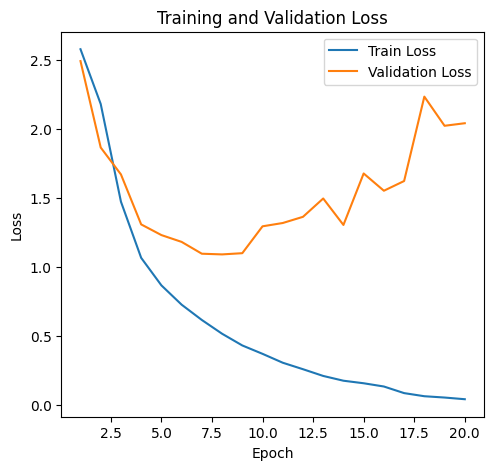

In [15]:
train_path = "/kaggle/input/dataset-llm/train.json"
valid_path = "/kaggle/input/dataset-llm/val.json"

opt_model, vocab = main_S4(
    train_path, valid_path, None,
    epochs=20,
    batch_size=16,
    max_len=64,
    emb_dim=128,
    num_layers=5,
    lr=5e-4
)

In [16]:
# predict on test.json
test_path = "/kaggle/input/dataset-llm/test.json"

def predict_test(model, vocab, test_path, batch_size=32, max_len=128, device="cuda"):
    test_texts, test_ids = load_dbpedia_data(train_path, valid_path, test_path)[4:6]
    test_loader = get_test_loader(test_texts, vocab, batch_size=batch_size, max_len=max_len)

    model.eval()
    predictions = []
    with torch.no_grad():
        for xb in tqdm(test_loader, desc="Predicting", unit="batch"):
            xb = xb.to(device)
            with torch.amp.autocast("cuda"):
                logits = model(xb)
            preds = logits.argmax(dim=1).cpu().tolist()
            predictions.extend(preds)

    return list(zip(test_ids, predictions))

preds = predict_test(opt_model, vocab, test_path, batch_size=16, max_len=64, device="cuda")

with open("fft_submission.csv", "w") as f:
    f.write("id,label\n")
    for idx, label in preds:
        f.write(f"{idx},{label}\n")

Predicting: 100%|██████████| 125/125 [00:00<00:00, 242.89batch/s]


### Observation
1. For basic SSM, the training time is 513.51 seconds for 20 epochs.
2. For S4, the training time is 112.58 seconds for 20 epochs.
   
